<a href="https://colab.research.google.com/github/Velociraptorvelraptor/pytorch-lightening-intel-img-classification/blob/main/intel_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir /root/.kaggle 

In [4]:
!mv /content/kaggle.json /root/.kaggle/kaggle.json

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 336M/346M [00:03<00:00, 130MB/s]
100% 346M/346M [00:03<00:00, 109MB/s]


In [6]:
!mv /content/intel-image-classification.zip '/content/drive/MyDrive/Colab Notebooks/intel-image-classification'

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/intel-image-classification/intel-image-classification.zip' -d '/content/drive/MyDrive/Colab Notebooks/intel-image-classification/data'



In [2]:
src_path = '/content/drive/MyDrive/Colab Notebooks/intel-image-classification'

In [3]:
train_path = src_path + '/data/seg_train/seg_train/'
test_path = src_path + '/data/seg_test/seg_test/'

In [4]:
train_path

'/content/drive/MyDrive/Colab Notebooks/intel-image-classification/data/seg_train/seg_train/'

In [ ]:
!pip install pytorch_lightning==1.8.5 torchvision torchmetrics

In [74]:
import os
from types import SimpleNamespace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.classification import MulticlassAccuracy
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchmetrics import ConfusionMatrix


In [34]:
transform = T.Compose([T.ToTensor(), 
                       T.Resize((64, 64)),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [35]:
train_dataset = ImageFolder(train_path, transform)
test_dataset = ImageFolder(test_path, transform)

In [36]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /content/drive/MyDrive/Colab Notebooks/intel-image-classification/data/seg_train/seg_train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [37]:
img, label = train_dataset[3]; img.shape

torch.Size([3, 64, 64])

In [38]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [39]:
train_idx = int(len(train_dataset) * 0.8)
val_idx = len(train_dataset) - train_idx

In [40]:
train_dataset, val_dataset = random_split(train_dataset, [train_idx, val_idx])

Text(0.5, 1.0, 'Encoded label: 0')

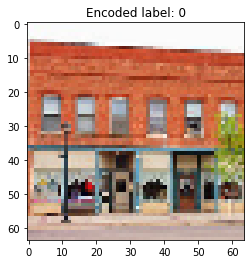

In [41]:
sample_img, sample_label = val_dataset.__getitem__(0)

plt.imshow(img_display(sample_img))
plt.title(f'Encoded label: {sample_label}')

In [42]:
BATCH_SIZE = 64

In [43]:
train_dl = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [93]:
def _conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class LitModel(pl.LightningModule):
    def __init__(self, in_channels=3, num_classes=6, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.train_accuracy = MulticlassAccuracy(self.num_classes)
        self.val_accuracy = MulticlassAccuracy(self.num_classes)
        self.test_accuracy = MulticlassAccuracy(self.num_classes)


                # Define PyTorch model
        self.conv1 = _conv_block(in_channels, 64)
        self.conv2 = _conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(_conv_block(128, 128), _conv_block(128, 128))
        
        self.conv3 = _conv_block(128, 256, pool=True)
        self.conv4 = _conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(_conv_block(512, 512), _conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, self.num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        #confmat = ConfusionMatrix(task="multiclass", num_classes=self.num_classes)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss)
        self.log("test_acc", self.test_accuracy)
        #self.log("conf_matrix", confmat(preds, y))



    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [94]:
model = LitModel(); model

LitModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=train_dl)

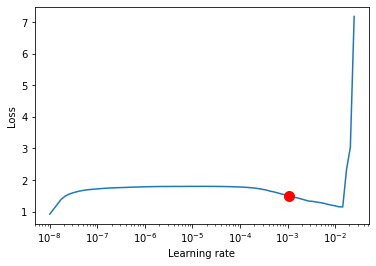

In [ ]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
new_lr = lr_finder.suggestion()

# update hyperparams of the model
model.learning_rate = new_lr

In [58]:
checkpoint_callback = ModelCheckpoint(dirpath=src_path + '/checkpoints/', save_top_k=2, monitor="val_loss")

In [60]:
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=20,
    logger=CSVLogger(save_dir="logs/"),
    limit_train_batches=0.2,
    limit_val_batches=0.05,
    callbacks=[checkpoint_callback])

trainer.fit(model, train_dl, val_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/intel-image-classification/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccura

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


,val_loss,val_acc,train_loss_epoch,train_acc_epoch,train_loss_step
epoch,,,,,
0,1.104801,0.595504,NaN,NaN,NaN
0,NaN,NaN,1.431100,0.444461,NaN
1,NaN,NaN,NaN,NaN,0.935717
1,0.718470,0.771889,NaN,NaN,NaN
1,NaN,NaN,0.967777,0.620889,NaN


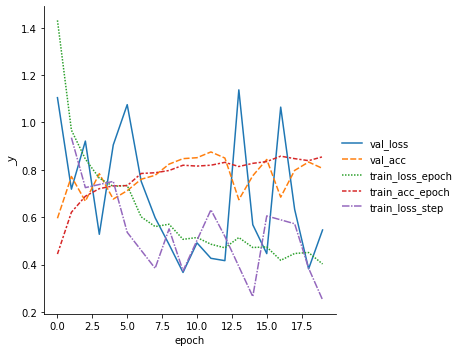

In [61]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sns.relplot(data=metrics, kind="line")